# TOKENIZER

Ce notebook présente une chaîne de traitement NLP complète en Python. Il couvre les étapes suivantes :

- Chargement et exploration du jeu de données
- Prétraitement du texte (tokenization avec regex et BPE, normalisation, stop words, lemmatisation)
- Extraction des caractéristiques (TF‑IDF)
- Entraînement et évaluation de modèles de classification (Naive Bayes et régression logistique)

Les étapes s'inspirent des documents de Gustave Cortal.


In [63]:
import unicodedata
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def plot_genre_distribution(df):
    genre_counts = df['genre'].value_counts()
    plt.figure(figsize=(8, 6))
    plt.bar(genre_counts.index, genre_counts.values, color='skyblue')
    plt.xlabel('Genre')
    plt.ylabel('Nombre de documents')
    plt.title('Distribution des genres')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_top_tokens(token_list, top_n=20):
    counter = Counter(token_list)
    common_tokens = counter.most_common(top_n)
    tokens, counts = zip(*common_tokens)
    plt.figure(figsize=(10, 6))
    plt.bar(tokens, counts, color='lightgreen')
    plt.xlabel('Tokens')
    plt.ylabel('Fréquence')
    plt.title(f'Top {top_n} tokens les plus fréquents')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matrice de confusion')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.tight_layout()
    plt.show()


In [64]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /Users/emre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/emre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/emre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# %load tokenizer.py
import os
import json
import re
import spacy
from collections import defaultdict, Counter

class BPETokenizer:
    def __init__(self, path=".datas/merges_bpe.json", num_merges=1000, dataset=None):
        self.path = path
        self.num_merges = num_merges
        self.merges = None
        self.nlp = spacy.load("fr_core_news_sm")

        if dataset is not None:
            self.learn_merges(dataset)
        elif os.path.exists(self.path):
            self._load_merges()

    def preprocess_sentence(self, sentence):
        doc = self.nlp(sentence.lower())
        tokens = [token.lemma_ for token in doc if token.is_alpha]
        return " ".join(tokens)

    def _get_vocab(self, corpus):
        vocab = defaultdict(int)
        for sentence in corpus:
            words = sentence.lower().split()
            for word in words:
                chars = list(word) + ['</w>']
                vocab[tuple(chars)] += 1
        return vocab

    def _get_stats(self, vocab):
        pairs = defaultdict(int)
        for word, freq in vocab.items():
            for i in range(len(word)-1):
                pairs[(word[i], word[i+1])] += freq
        return pairs

    def _merge_vocab(self, pair, vocab):
        new_vocab = {}
        bigram = pair
        replacement = ''.join(bigram)
        for word, freq in vocab.items():
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word)-1 and word[i] == bigram[0] and word[i+1] == bigram[1]:
                    new_word.append(replacement)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_vocab[tuple(new_word)] = freq
        return new_vocab

    def learn_merges(self, dataset):
        print("Apprentissage des merges BPE...")
        preprocessed = [self.preprocess_sentence(s) for s in dataset]
        vocab = self._get_vocab(preprocessed)
        merges = []

        for i in range(self.num_merges):
            pairs = self._get_stats(vocab)
            if not pairs:
                break
            best = max(pairs, key=pairs.get)
            vocab = self._merge_vocab(best, vocab)
            merges.append(best)

        self.merges = merges
        self._save_merges()
        print(f"{len(merges)} merges appris et saved.")

    def _apply_bpe_to_word(self, word):
        word = list(word) + ["</w>"]
        for merge in self.merges:
            i = 0
            while i < len(word) - 1:
                if word[i] == merge[0] and word[i + 1] == merge[1]:
                    word[i:i + 2] = ["".join(merge)]
                else:
                    i += 1
        return word

    def _load_merges(self):
        with open(self.path, "r", encoding="utf-8") as f:
            merges = json.load(f)
        self.merges = [tuple(pair) for pair in merges]

    def _save_merges(self):
        os.makedirs(os.path.dirname(self.path), exist_ok=True)
        with open(self.path, "w", encoding="utf-8") as f:
            json.dump(self.merges, f, ensure_ascii=False, indent=2)

    def _clean_text(self, text):
        text = text.lower()
        text = re.sub(r"[^\w\s']", " ", text)  # garder les apostrophes
        text = re.sub(r"\s+", " ", text).strip()
        return text

    def tokenize(self, text):
        text = self.preprocess_sentence(text)
        tokens = []
        for word in text.split():
            tokens.extend(self._apply_bpe_to_word(word))
        return tokens

    def __call__(self, text):
        return self.tokenize(text)


In [ ]:
def read_folder(folder):
    texts = []
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
    return texts


In [70]:
folder = "../lyrics_dataset/"

texts = read_folder(folder)

tokenizer = BPETokenizer(path=".datas/merges_bpe.json", num_merges=3760, dataset=texts)


In [75]:
tokenizer.tokenize("bordel quand on rentre, bonjour le monde!!")


['bordel</w>',
 'quand</w>',
 'on</w>',
 'rentrer</w>',
 'bon',
 'jour</w>',
 'le</w>',
 'monde</w>']

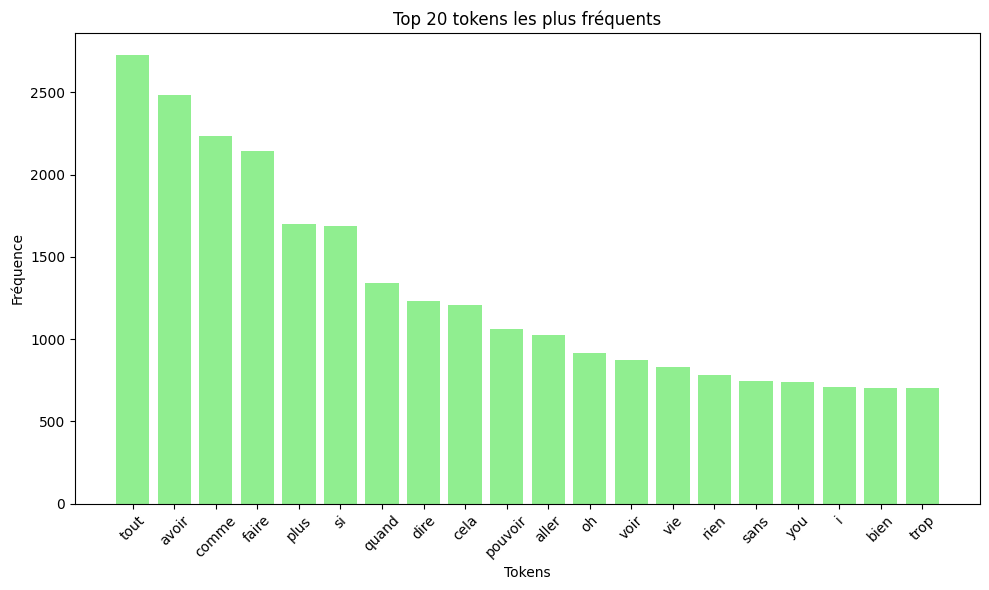

Règles BPE apprises : [('r', '</w>'), ('e', '</w>'), ('e', 'r</w>'), ('o', 'n'), ('e', 'n'), ('i', 'n'), ('t', '</w>'), ('a', 'n'), ('o', 'u'), ('a', 'r'), ('c', 'h'), ('a', 'l'), ('i', 's'), ('r', 'a'), ('r', 'e'), ('t', 'i'), ('r', 'e</w>'), ('r', 'i'), ('l', '</w>'), ('q', 'u'), ('r', 'o'), ('on', '</w>'), ('e', 'r'), ('e', 'u'), ('i', 'l'), ('i', '</w>'), ('c', 'o'), ('d', 'é'), ('l', 'a'), ('s', 's'), ('d', '</w>'), ('t', 'er</w>'), ('o', '</w>'), ('t', 'a'), ('l', 'i'), ('m', 'a'), ('o', 'r'), ('t', 'e</w>'), ('a', '</w>'), ('é', '</w>'), ('e', 'm'), ('y', '</w>'), ('en', 't</w>'), ('c', 'a'), ('s', '</w>'), ('l', 'e</w>'), ('r', 'é'), ('l', 'er</w>'), ('d', 'i'), ('g', '</w>'), ('i', 'r</w>'), ('in', '</w>'), ('l', 'o'), ('c', 'on'), ('a', 'u'), ('s', 't'), ('a', 'm'), ('p', 'a'), ('e', 'l'), ('eu', 'r</w>'), ('al', '</w>'), ('e', 't'), ('p', 'o'), ('i', 't'), ('r', 'er</w>'), ('g', 'u'), ('s', 'u'), ('b', 'a'), ('n', '</w>'), ('m', '</w>'), ('c', 'i'), ('c', 'e</w>'), ('e', 's'

In [ ]:
folder = "lyrics_dataset/"
texts = read_folder(folder)

bpe_merges = rules_bpe(pd.Series(texts))


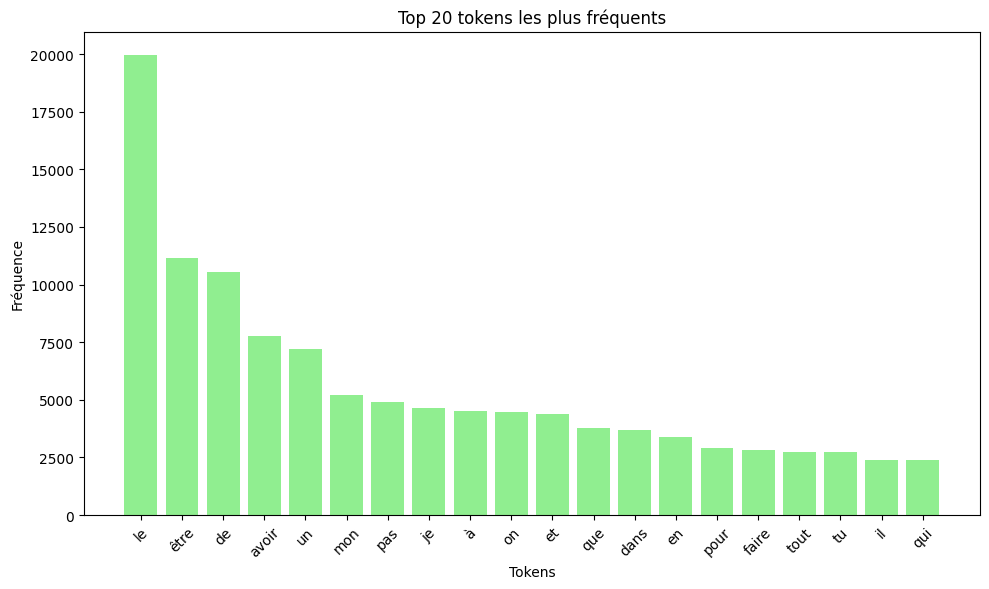

In [58]:
folder = "../lyrics_dataset/"
texts = read_folder(folder)
merges = learn_bpe(texts, num_merges=3750)
